## Import

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import box
import pandas as pd
from collections import defaultdict

## GeoPKG to GeoJSON

In [2]:
# Load the GeoPackage file (adjust layer name if needed)
gpkg_path = "data/raw/carte 1928 christelle.gpkg"

gdf = gpd.read_file(gpkg_path)

# Save to GeoJSON
geojson_path = "data/raw_geojson/roads_1_1928.geojson"
gdf.to_file(geojson_path, driver="GeoJSON")

print(f"GeoJSON file saved at: {geojson_path}")

GeoJSON file saved at: data/raw_geojson/roads_1_1928.geojson


## Map Visualisation

In [91]:
roads_2025_path = "data/processed/roads_2025.geojson"
roads_2025_gdf = gpd.read_file(roads_2025_path)

roads_1975_path = "data/processed/roads_1975.geojson"
roads_1975_gdf = gpd.read_file(roads_1975_path)

roads_1928_path = "data/processed/roads_1928.geojson"
roads_1928_gdf = gpd.read_file(roads_1928_path)

roads_1875_path = "data/processed/roads_1875.geojson"
roads_1875_gdf = gpd.read_file(roads_1875_path)

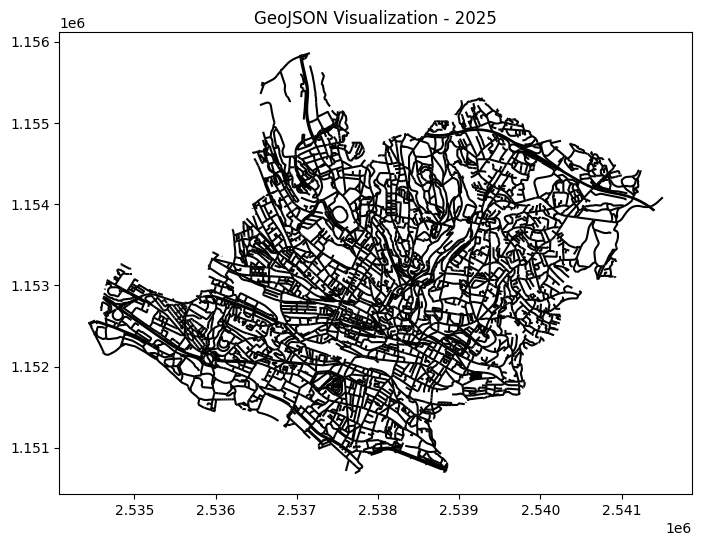

In [21]:
# Plot the GeoJSON file
roads_2025_gdf.plot(figsize=(10, 6), edgecolor="black", cmap="viridis")
plt.title("GeoJSON Visualization - 2025")
plt.show()

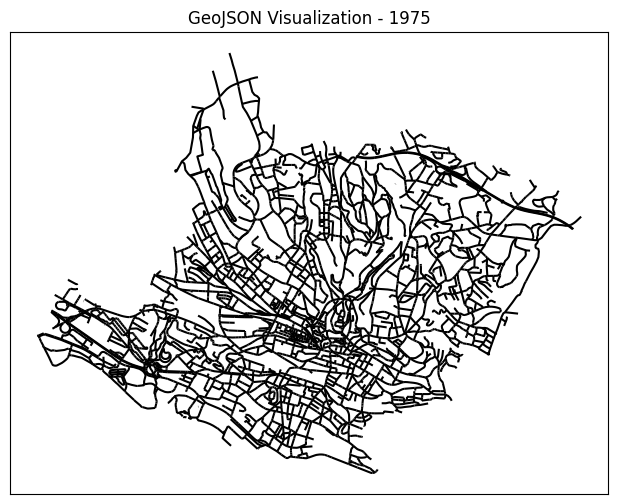

In [22]:
# Plot the GeoJSON file
roads_1975_gdf.plot(figsize=(10, 6), edgecolor="black", cmap="viridis")
plt.title("GeoJSON Visualization - 1975")
plt.xticks([])
plt.yticks([])
plt.savefig("GeoJSON_1975.jpg",dpi=600)
plt.show()

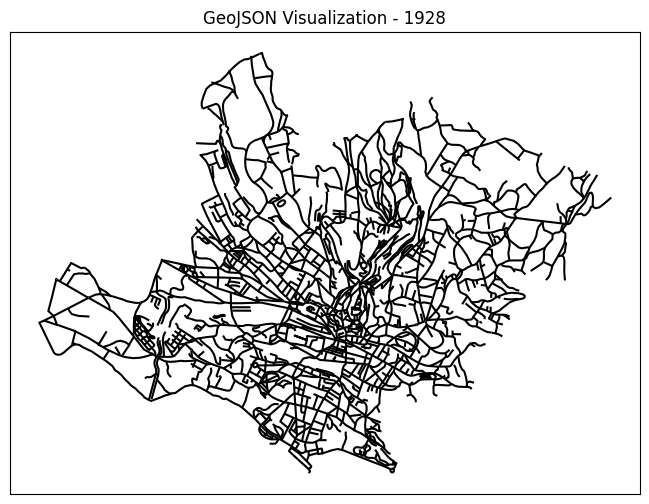

In [92]:
# Plot the GeoJSON file
roads_1928_gdf.plot(figsize=(10, 6), edgecolor="black", cmap="viridis")
plt.title("GeoJSON Visualization - 1928")
plt.xticks([])
plt.yticks([])
plt.savefig("GeoJSON_1928.jpg",dpi=600)
plt.show()

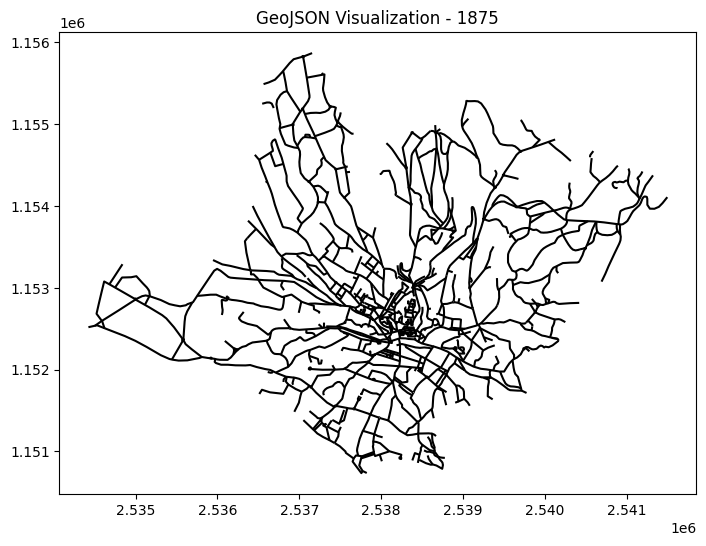

In [24]:
# Plot the GeoJSON file
roads_1875_gdf.plot(figsize=(10, 6), edgecolor="black", cmap="viridis")
plt.title("GeoJSON Visualization - 1875")
plt.show()

## Functions and first example

In [25]:
MEAN_WIDTH = 3.418189974206572
MAX_WIDTH = 8

# Load GeoJSON with roads
def load_roads(geojson_path):
    return gpd.read_file(geojson_path)

# Create a grid of square patches over the bounding box of the roads
def create_grid(gdf, n_patches, bounds):
    minx, miny, maxx, maxy = bounds
    x_grid = np.linspace(minx, maxx, n_patches + 1)
    y_grid = np.linspace(miny, maxy, n_patches + 1)
    
    grid = []
    for i in range(n_patches):
        for j in range(n_patches):
            cell = box(x_grid[i], y_grid[j], x_grid[i+1], y_grid[j+1])
            grid.append(cell)
    
    grid_gdf = gpd.GeoDataFrame(geometry=grid, crs=gdf.crs)
    return grid_gdf

# Compute road density in each patch (total road length / patch area)
def compute_density(grid_gdf, roads_gdf):
    densities_length = []
    # densities_area = []
    
    for idx, patch in enumerate(grid_gdf.geometry):
        roads_in_patch = roads_gdf[roads_gdf.intersects(patch)].copy()
        roads_in_patch = gpd.clip(roads_gdf, patch)
        if len(roads_in_patch) > 0:
            # roads_in_patch["Shape_Width"] = roads_in_patch["OBJEKTART"].apply(lambda x: x[0])

            # roads_in_patch.loc[roads_in_patch.Shape_Width == "A", "Shape_Width"] = str(MAX_WIDTH)
            # roads_in_patch.loc[roads_in_patch.Shape_Width.isin(["P","D"]), "Shape_Width"] = str(MEAN_WIDTH)
            # roads_in_patch.loc[roads_in_patch.Shape_Width == "E", "Shape_Width"] = str(3)

            # roads_in_patch["Shape_Width"] = roads_in_patch["Shape_Width"].astype(float)
            total_road_length = roads_in_patch.length.sum()
            # total_road_area = (roads_in_patch.length * roads_in_patch.Shape_Width).sum()
        
            patch_area = patch.area
            density_length = total_road_length / patch_area if patch_area > 0 else 0
            # density_area = total_road_area / patch_area if patch_area > 0 else 0
        else:
            # density_area = 0
            density_length = 0
        densities_length.append(density_length)
        # densities_area.append(density_area)
    
    grid_gdf["road_density_length"] = densities_length
    # grid_gdf["road_density_area"] = densities_area
    return grid_gdf

# Full pipeline: Compute road density over a grid
def compute_road_density_map(roads_gdf, bounds, n_patches=10):
    grid_gdf = create_grid(roads_gdf, n_patches, bounds)
    density_gdf = compute_density(grid_gdf, roads_gdf)
    
    return density_gdf

# Visualization
def plot_density_map(density_gdf, roads_gdf, year):
    fig, ax = plt.subplots(1,1,figsize=(15, 10))
    density_gdf.plot(column="road_density_length", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax)
    roads_gdf.plot(color="black", linewidth=0.5, alpha=0.5, ax=ax)
    ax.set_title(f"Road Length Density Map {str(year)}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    #density_gdf.plot(column="road_density_area", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax[1])
    #roads_gdf.plot(color="black", linewidth=0.5, alpha=0.5, ax=ax[1])
    #ax[1].set_title(f"Road Area Density Map {str(year)}")
    plt.show()

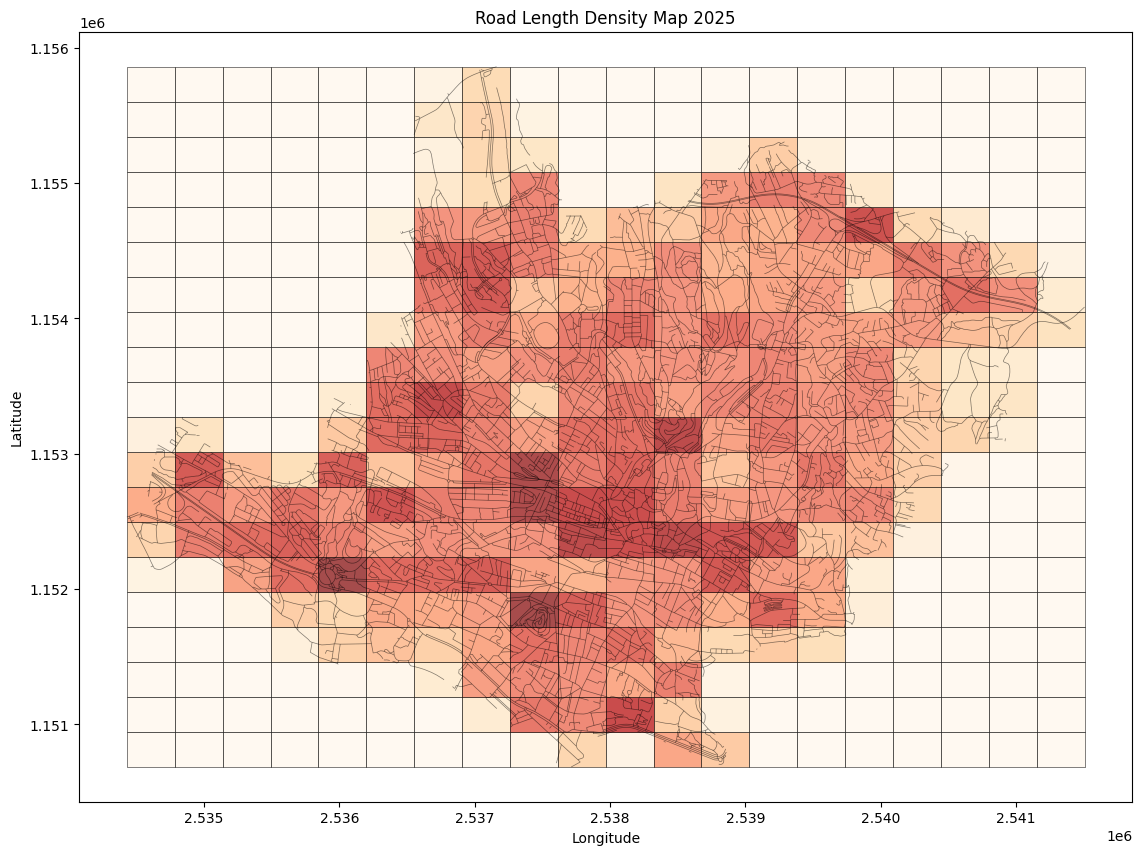

In [16]:
# Example usage
geojson_path = "data/processed/roads_2025.geojson"  # Replace with your file path
n_patches = 20
roads_gdf = load_roads(geojson_path)

# P: Platz -> mean
# A: Autobahn -> max
# E: Einfahrt -> 3
# D: Dienstzufahrt -> mean

density_gdf = compute_road_density_map(roads_gdf, roads_gdf.total_bounds, n_patches)
plot_density_map(density_gdf, roads_gdf, 2025)

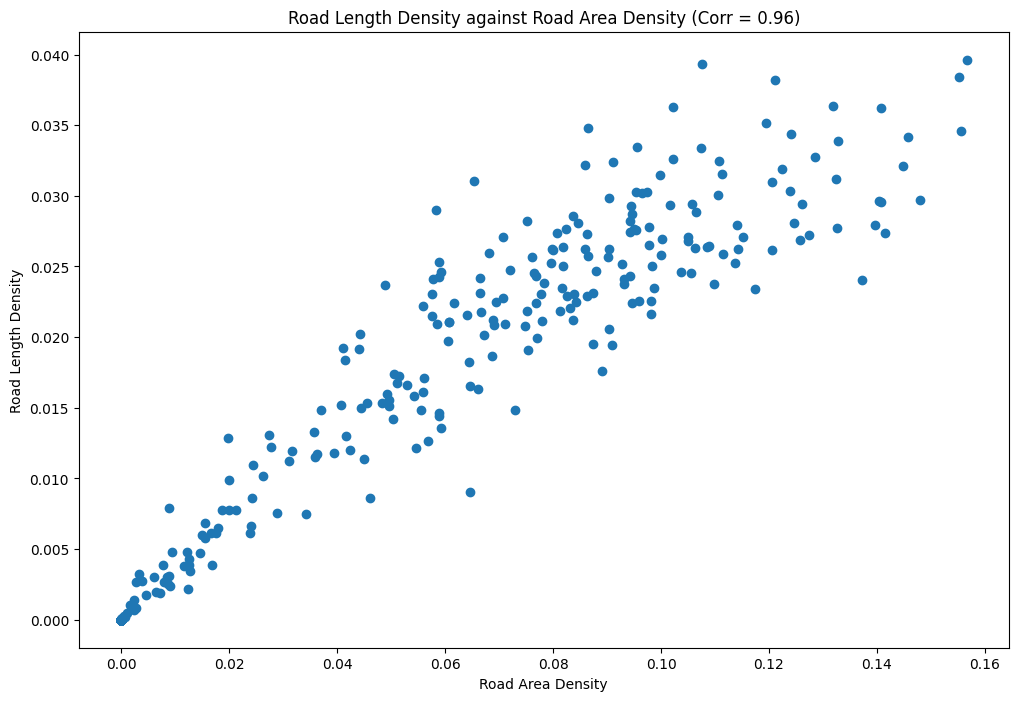

In [17]:
plt.figure(figsize=(12,8))
correlation = density_gdf["road_density_area"].corr(density_gdf["road_density_length"])
plt.scatter(density_gdf.road_density_area, density_gdf.road_density_length)
plt.xlabel("Road Area Density")
plt.ylabel("Road Length Density")
plt.title(f"Road Length Density against Road Area Density (Corr = {round(correlation,2)})")
plt.show()

## 1975 to 2025

In [26]:
roads_2025_path = "data/processed/roads_2025.geojson"
roads_2025_gdf = gpd.read_file(roads_2025_path)

roads_1975_path = "data/processed/roads_1975.geojson"
roads_1975_gdf = gpd.read_file(roads_1975_path)

roads_1928_path = "data/processed/roads_1928.geojson"
roads_1928_gdf = gpd.read_file(roads_1928_path)

roads_1875_path = "data/processed/roads_1875.geojson"
roads_1875_gdf = gpd.read_file(roads_1875_path)

gdfs = [roads_1875_gdf, roads_1928_gdf, roads_1975_gdf,roads_2025_gdf]

In [74]:
N_PATCHES = 30

boundaries = defaultdict(list)

for gdf_year in gdfs:
    minx_year, miny_year, maxx_year, maxy_year = gdf_year.total_bounds
    boundaries["min_x"].append(minx_year)
    boundaries["min_y"].append(miny_year)
    boundaries["max_x"].append(maxx_year)
    boundaries["max_y"].append(maxy_year)

minx = min(boundaries["min_x"])
miny = min(boundaries["min_y"])
maxx = min(boundaries["max_x"])
maxy = min(boundaries["max_y"])

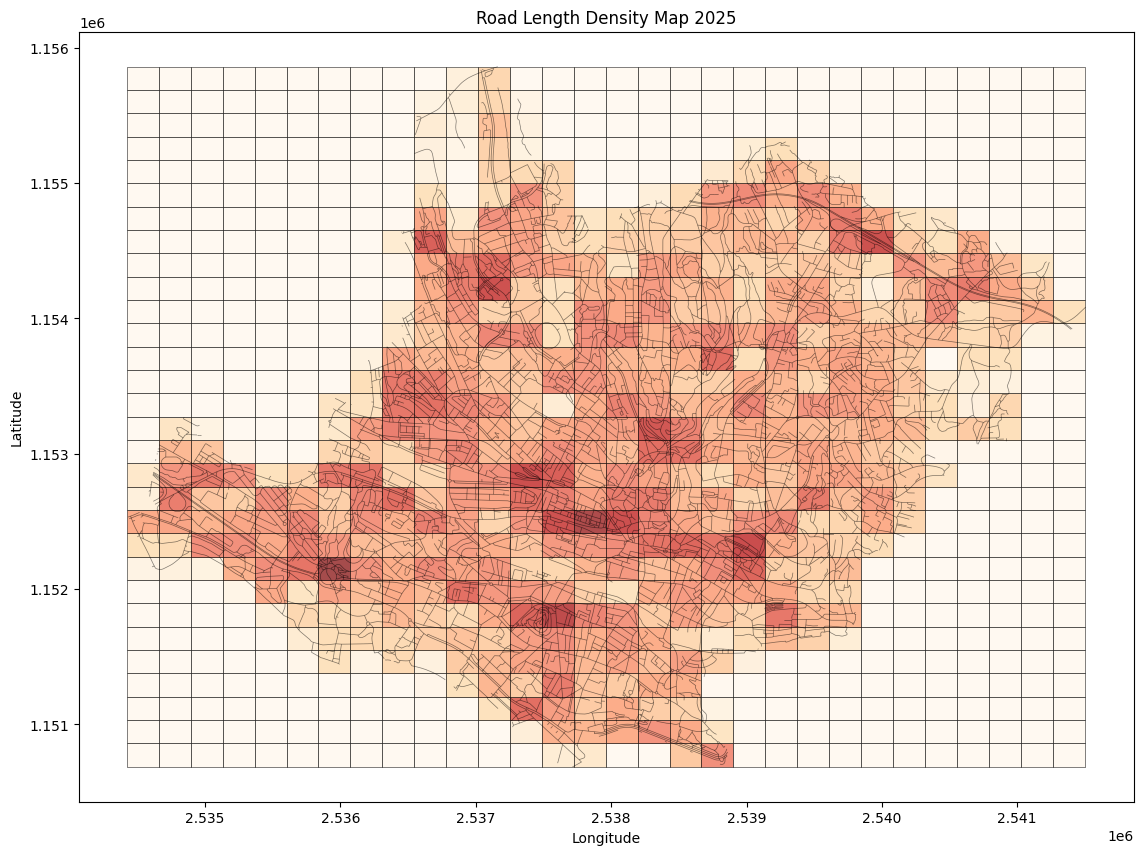

In [75]:
density_2025_gdf = compute_road_density_map(roads_2025_gdf, (minx, miny, maxx, maxy), N_PATCHES)
plot_density_map(density_2025_gdf, roads_2025_gdf, 2025)

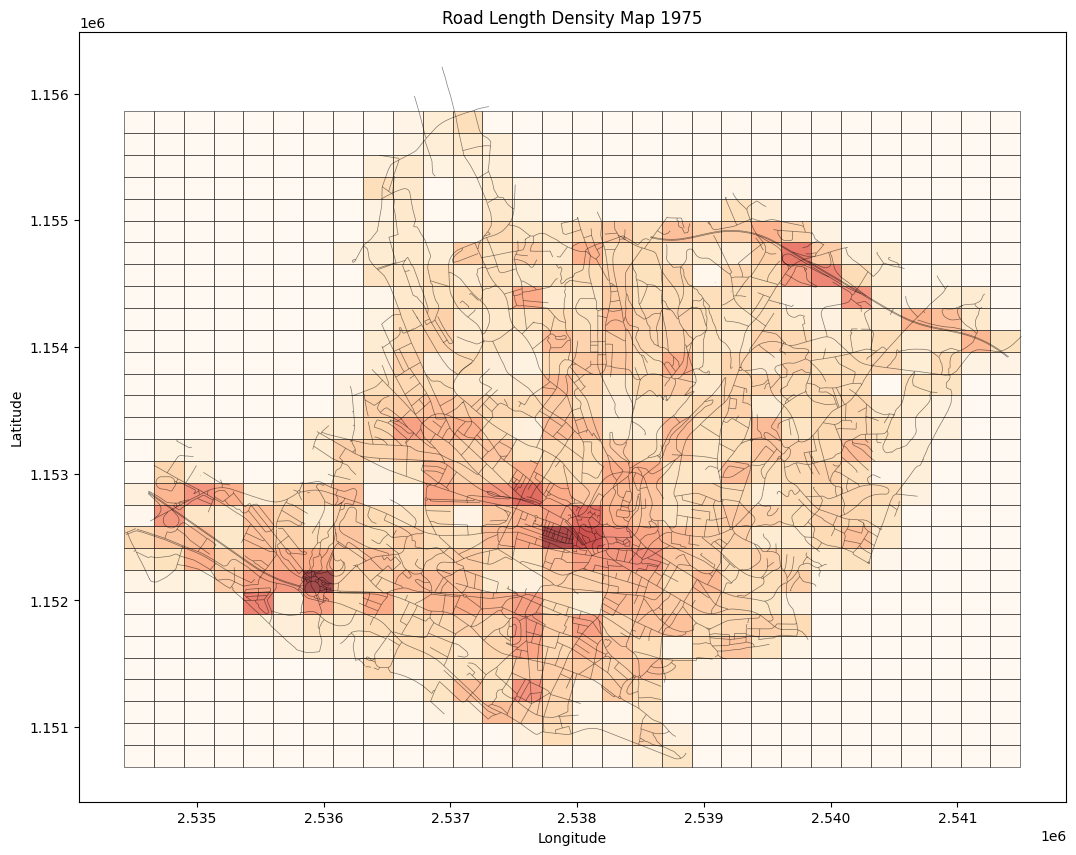

In [76]:
density_1975_gdf = compute_road_density_map(roads_1975_gdf, (minx, miny, maxx, maxy), N_PATCHES)
plot_density_map(density_1975_gdf, roads_1975_gdf, 1975)

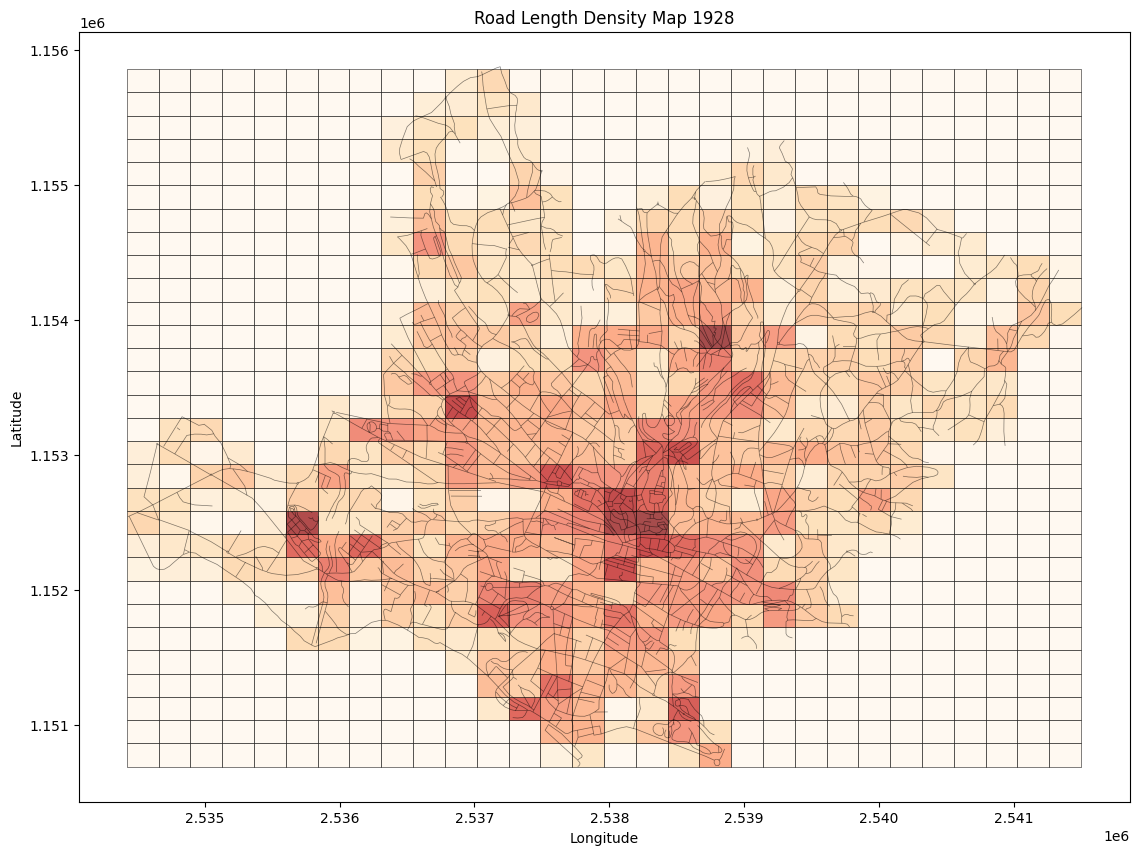

In [77]:
density_1928_gdf = compute_road_density_map(roads_1928_gdf, (minx, miny, maxx, maxy), N_PATCHES)
plot_density_map(density_1928_gdf, roads_1928_gdf, 1928)

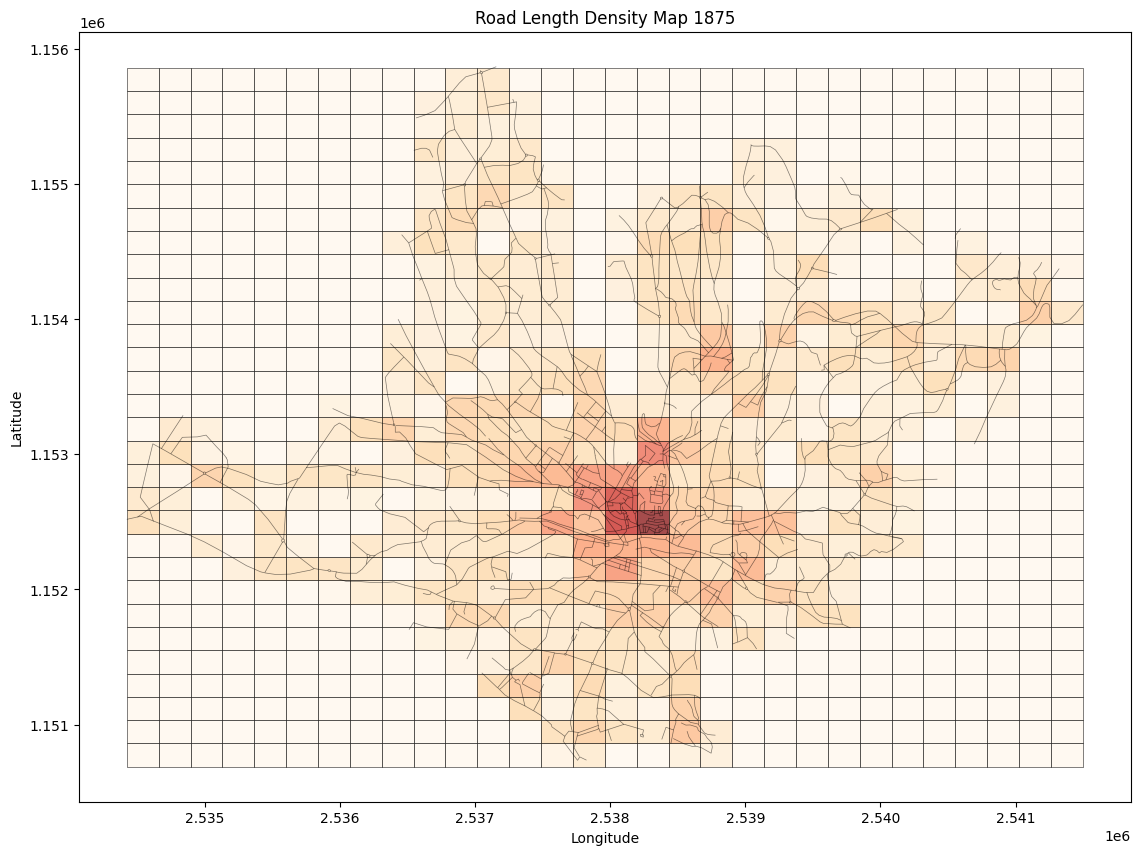

In [78]:
density_1875_gdf = compute_road_density_map(roads_1875_gdf, (minx, miny, maxx, maxy), N_PATCHES)
plot_density_map(density_1875_gdf, roads_1875_gdf, 1875)

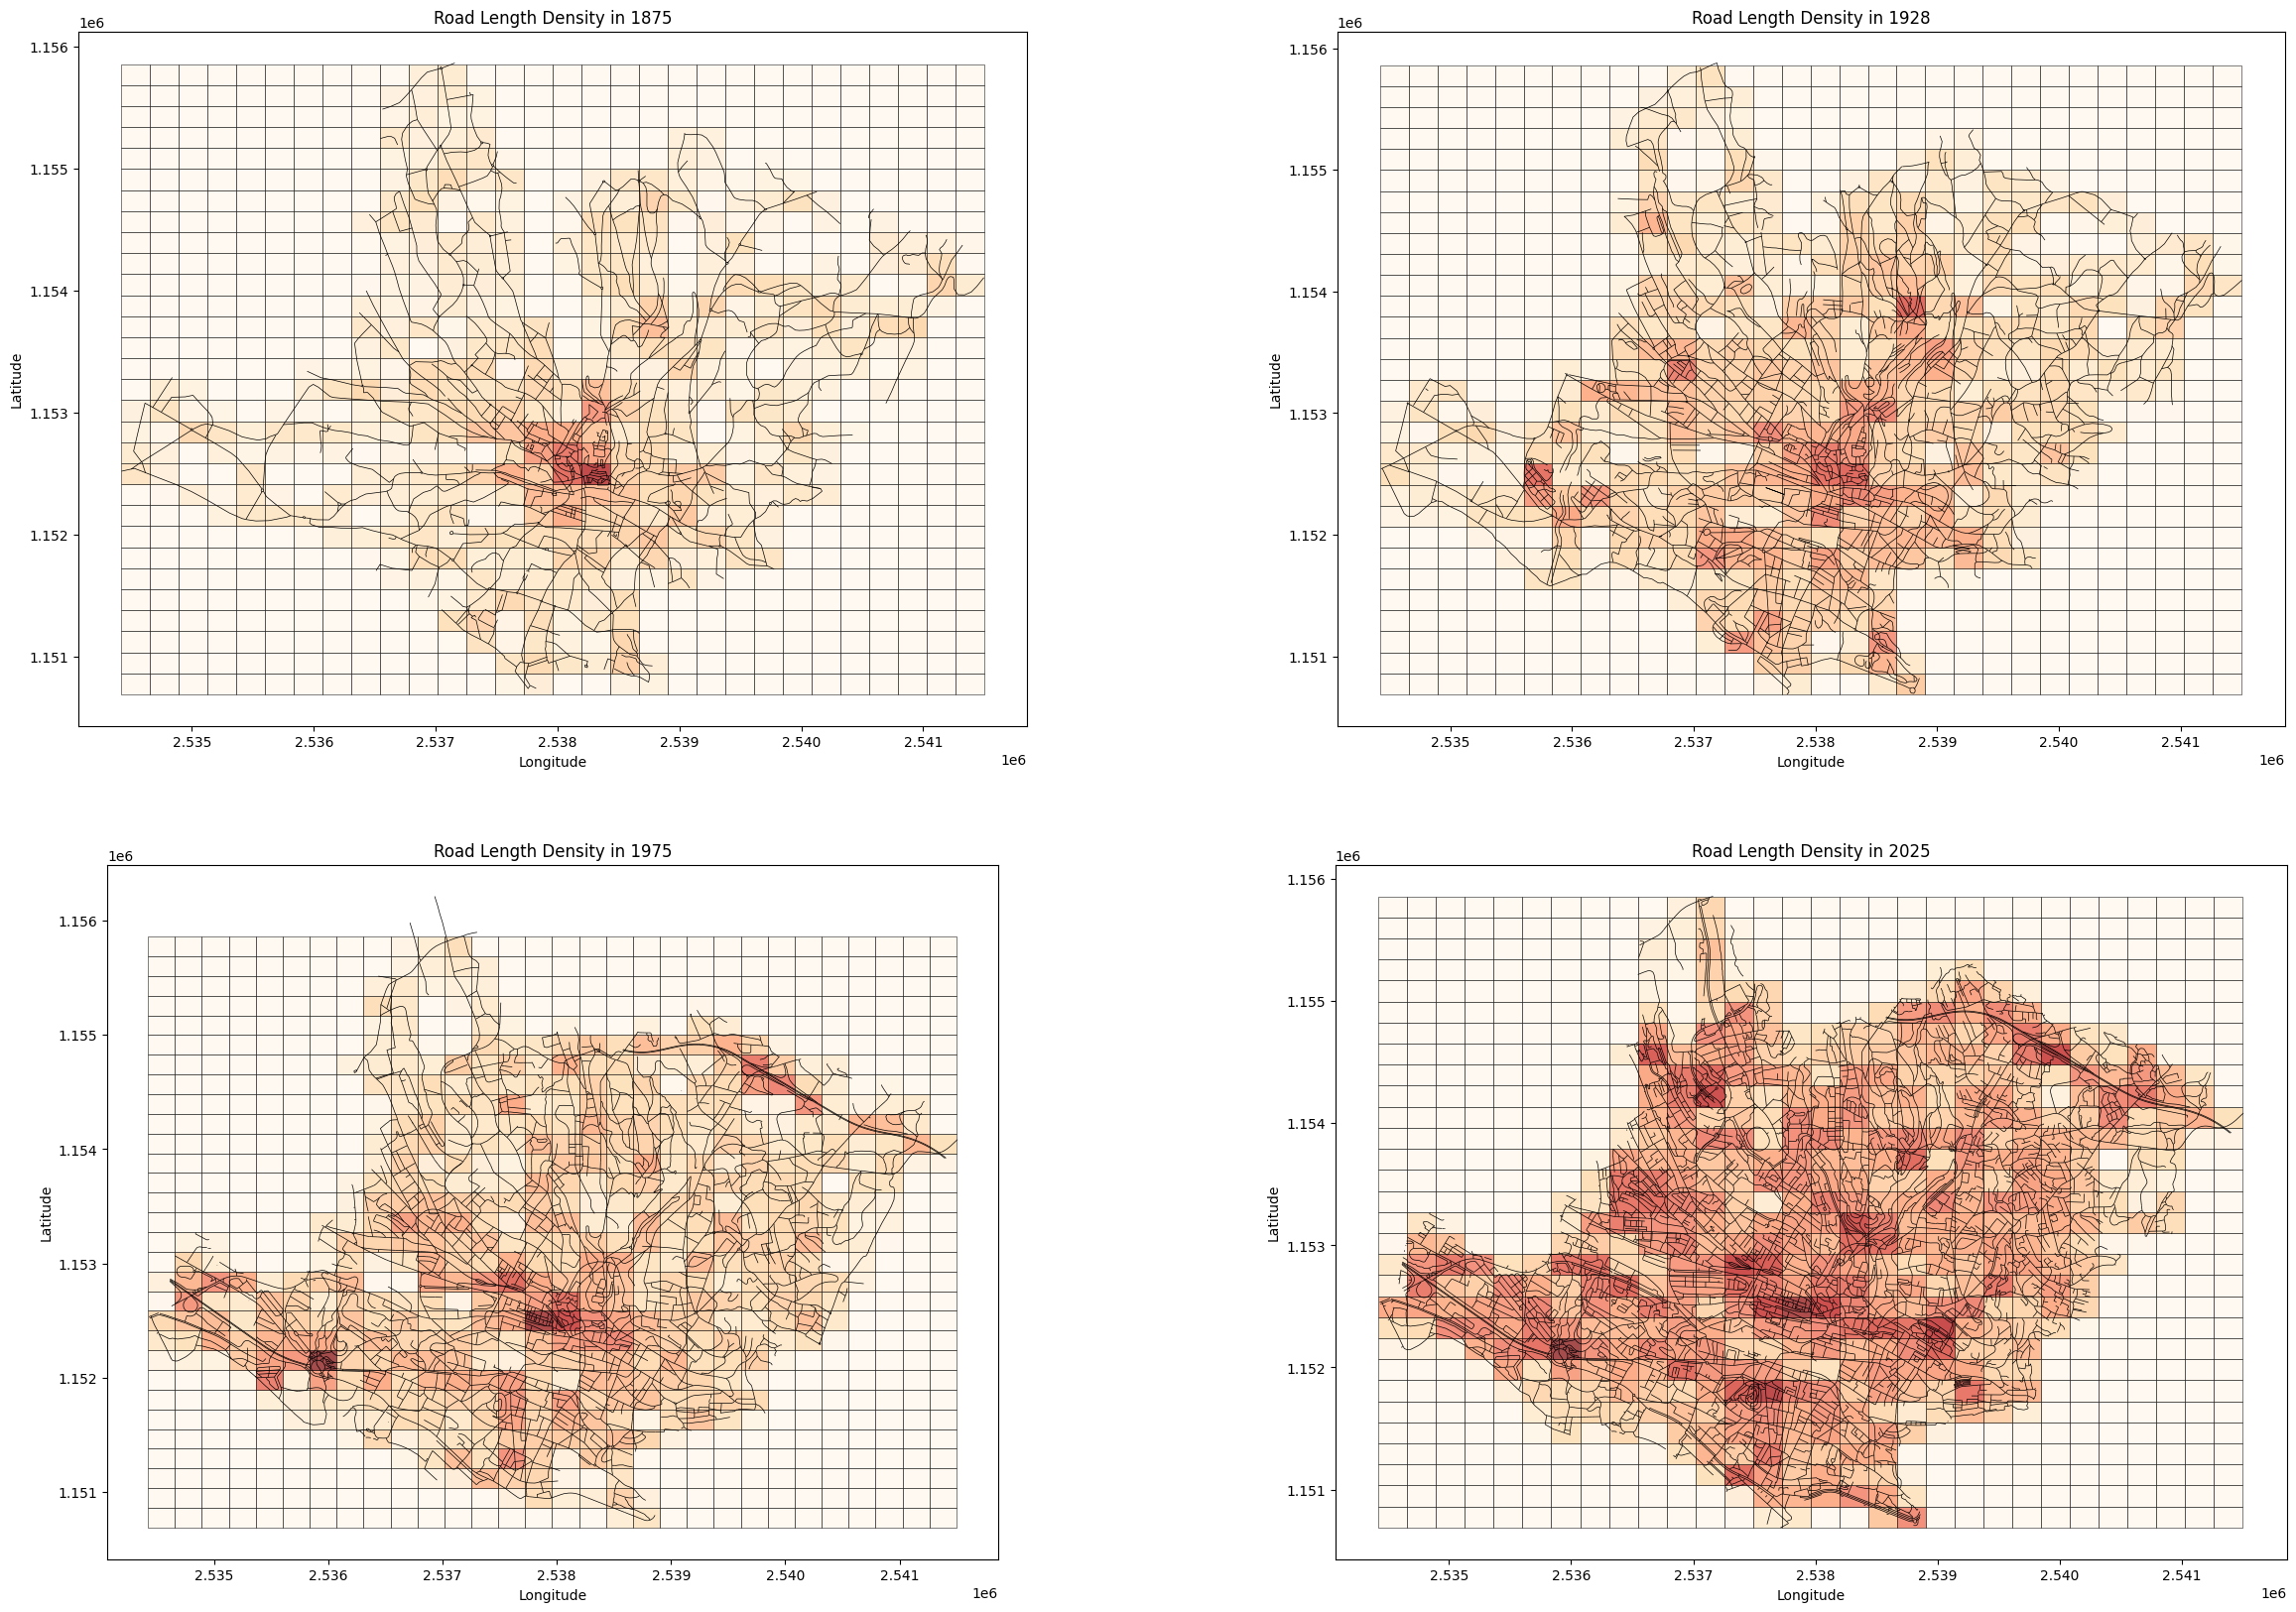

In [79]:
fig, ax = plt.subplots(2,2,figsize=(30, 20))

vmin = 0
vmax = max(density_1875_gdf.road_density_length.max(),density_1928_gdf.road_density_length.max(),density_1975_gdf.road_density_length.max(),density_2025_gdf.road_density_length.max())

density_1875_gdf.plot(column="road_density_length", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax[0][0], vmin=vmin, vmax=vmax)
roads_1875_gdf.plot(color="black", linewidth=0.5, alpha=1, ax=ax[0][0])
ax[0][0].set_title("Road Length Density in 1875")
ax[0][0].set_xlabel("Longitude")
ax[0][0].set_ylabel("Latitude")

density_1928_gdf.plot(column="road_density_length", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax[0][1], vmin=vmin, vmax=vmax)
roads_1928_gdf.plot(color="black", linewidth=0.5, alpha=1, ax=ax[0][1])
ax[0][1].set_title("Road Length Density in 1928")
ax[0][1].set_xlabel("Longitude")
ax[0][1].set_ylabel("Latitude")

density_1975_gdf.plot(column="road_density_length", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax[1][0], vmin=vmin, vmax=vmax)
roads_1975_gdf.plot(color="black", linewidth=0.5, alpha=1, ax=ax[1][0])
ax[1][0].set_title("Road Length Density in 1975")
ax[1][0].set_xlabel("Longitude")
ax[1][0].set_ylabel("Latitude")

density_2025_gdf.plot(column="road_density_length", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=ax[1][1], vmin=vmin, vmax=vmax)
roads_2025_gdf.plot(color="black", linewidth=0.5, alpha=1, ax=ax[1][1])
ax[1][1].set_title("Road Length Density in 2025")
ax[1][1].set_xlabel("Longitude")
ax[1][1].set_ylabel("Latitude")

plt.show()

In [80]:
density_1928_gdf.to_crs(epsg=4326).to_file(f"data/outputs/density_1928_wgs84_n{N_PATCHES}.geojson")

In [81]:
densities_gdf = [density_1928_gdf, density_1975_gdf, density_2025_gdf]
years = [1875, 1928, 1975, 2025]

In [82]:
gdf_comparison = density_1875_gdf.copy()
gdf_comparison.rename(columns={"road_density_length":"road_density_length_1875"},inplace=True)

for i in range(len(densities_gdf)):
    prev_year = years[i]
    year = years[i+1]
    gdf = densities_gdf[i].rename(columns={"road_density_length":f"road_density_length_{year}"})
    gdf_comparison = gdf_comparison.merge(gdf, how="inner", on="geometry")
    gdf_comparison[f"{prev_year}_to_{year}"] = gdf_comparison[f"road_density_length_{year}"] - gdf_comparison[f"road_density_length_{prev_year}"]

In [83]:
gdf_comparison['centroid'] = gdf_comparison.geometry.centroid
spatial_index = gdf_comparison.sindex

mean_values = defaultdict(list)

for idx, row in gdf_comparison.iterrows():
    center = row['centroid']
    
    # Define a search box around the centroid (to capture 8 neighbors + self)
    # Assuming your grid has consistent spacing (e.g., 87 meters between centroids based on your polygon)
    buffer_distance = 50  # adjust based on your grid spacing
    bounds = center.buffer(buffer_distance).bounds
    possible_matches_index = list(spatial_index.intersection(bounds))
    possible_matches = gdf_comparison.iloc[possible_matches_index]
    
    # Filter to real neighbors: same-sized patches & touching or nearby centroids
    nearby = possible_matches[possible_matches['centroid'].distance(center) <= buffer_distance * 1.5]
    
    # Compute mean of the 'value' column
    for i in range(len(years)-1):
        mean_val = nearby[f"{years[i]}_to_{years[i+1]}"].mean()
        mean_values[f"{years[i]}_to_{years[i+1]}"].append(mean_val)

# Step 4: Assign the new mean values to a new column
for key in mean_values:
    gdf_comparison[key+'_smoothed_value'] = mean_values[key]

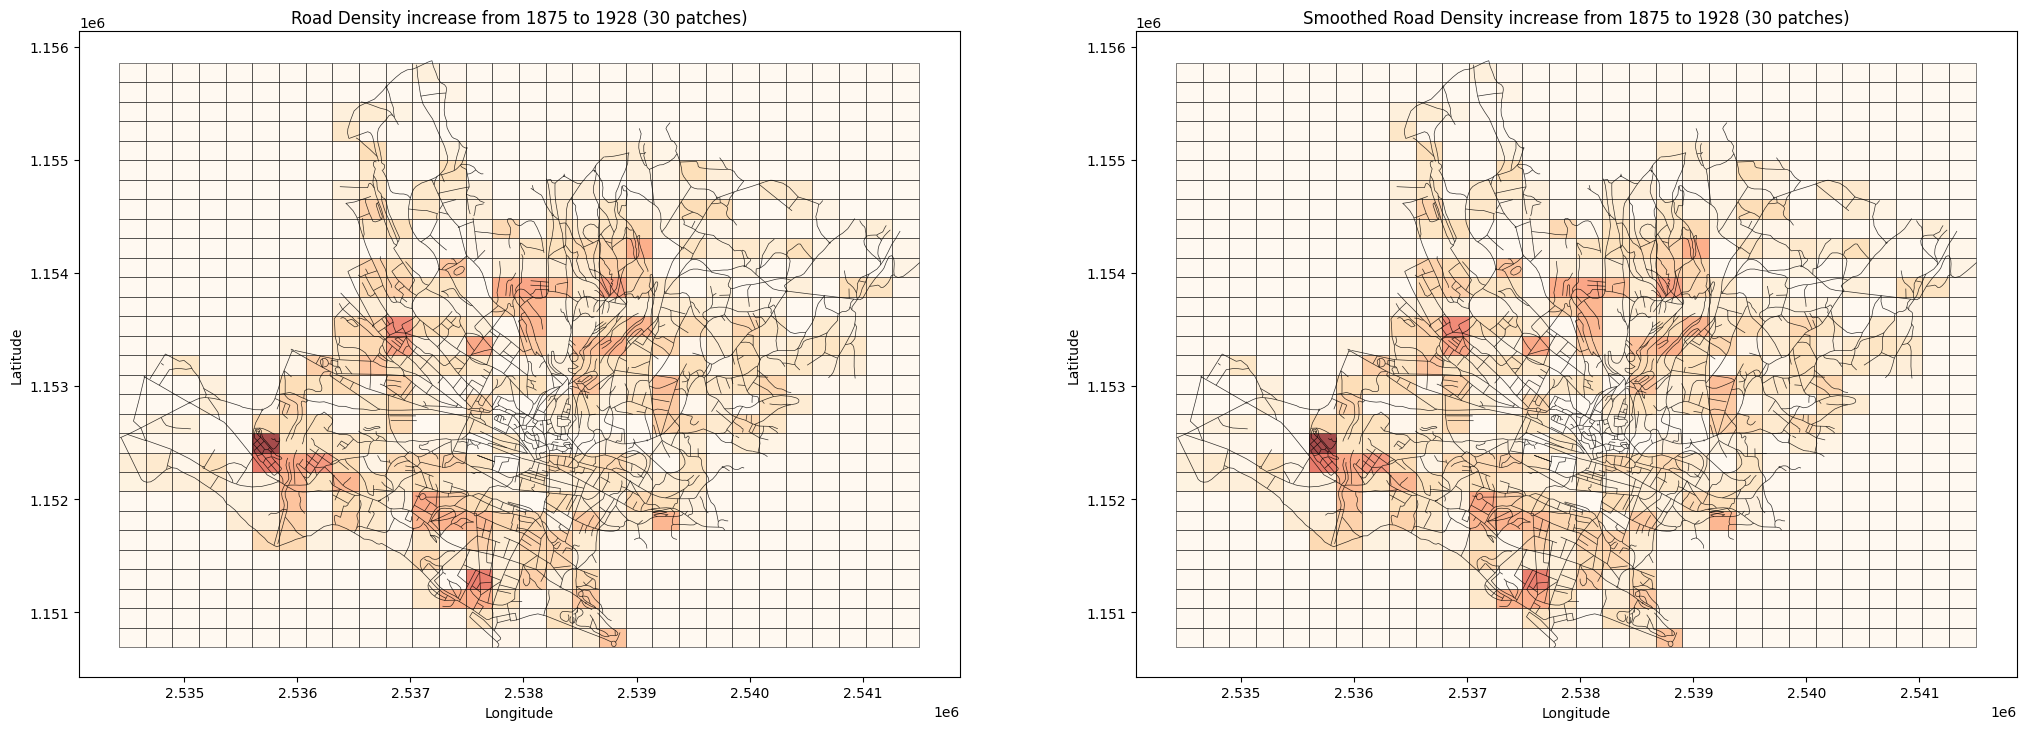

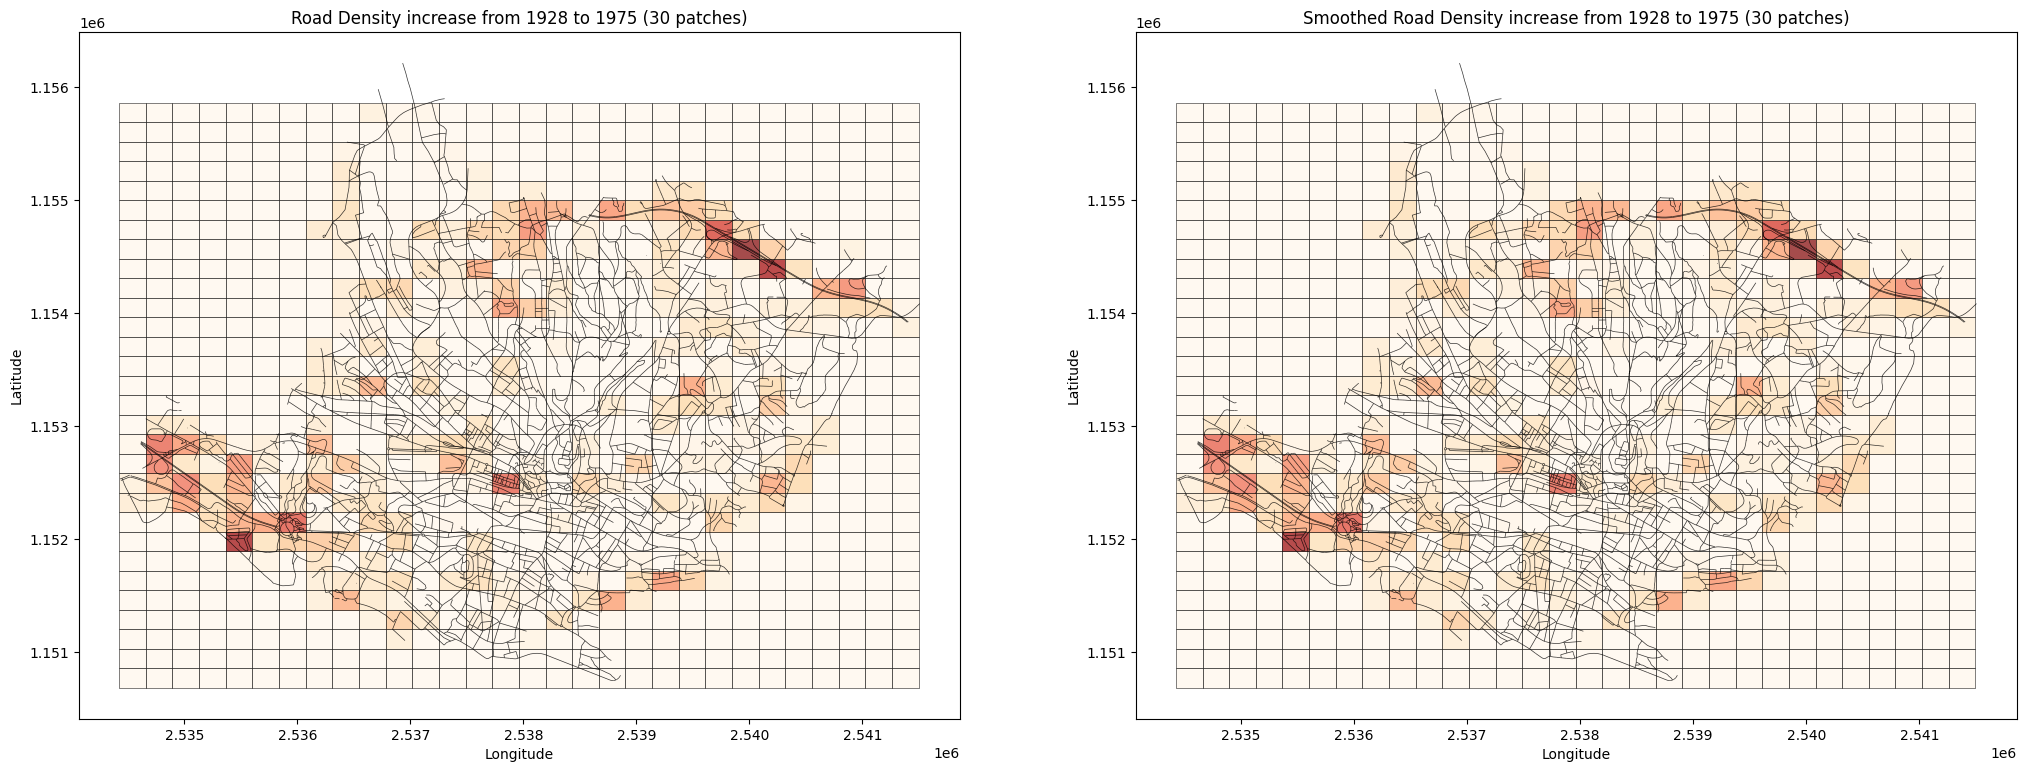

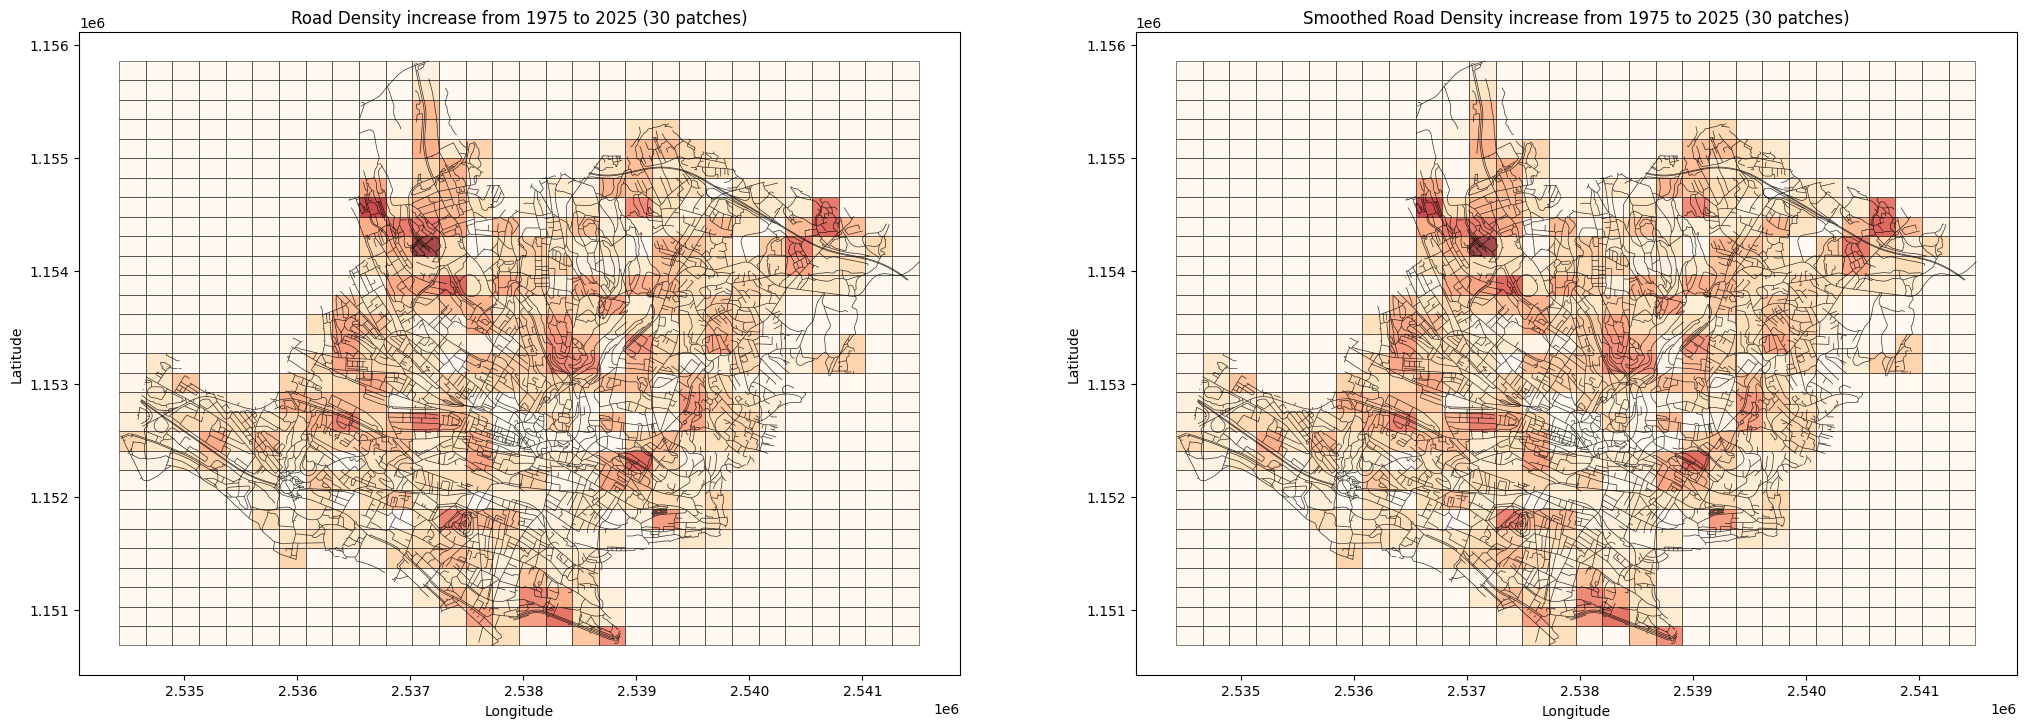

In [84]:
for i in range(len(years)-1):

    fig, axs = plt.subplots(1,2,figsize=(25, 10))

    year = years[i]
    next_year = years[i+1]

    vmin = 0
    vmax = gdf_comparison[f"{year}_to_{next_year}"].max()

    gdf_comparison.plot(column=f"{year}_to_{next_year}", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=axs[0], vmin=vmin, vmax=vmax)
    gdfs[i+1].plot(color="black", linewidth=0.5, alpha=0.8, ax=axs[0])
    axs[0].set_xlabel("Longitude")
    axs[0].set_ylabel("Latitude")
    axs[0].set_title(f"Road Density increase from {year} to {next_year} ({N_PATCHES} patches)")

    gdf_comparison.plot(column=f"{year}_to_{next_year}_smoothed_value", cmap="OrRd", linewidth=0.5, edgecolor="black", alpha=0.7, legend=False, ax=axs[1], vmin=vmin, vmax=vmax)
    gdfs[i+1].plot(color="black", linewidth=0.5, alpha=0.8, ax=axs[1])
    axs[1].set_xlabel("Longitude")
    axs[1].set_ylabel("Latitude")
    axs[1].set_title(f"Smoothed Road Density increase from {year} to {next_year} ({N_PATCHES} patches)")

    plt.show()

In [ ]:
density_2025_gdf.to_crs('EPSG:4326').to_file(f"data/outputs/density_2025_wgs84_n{N_PATCHES}.geojson")
density_1975_gdf.to_crs('EPSG:4326').to_file(f"data/outputs/density_1975_wgs84_n{N_PATCHES}.geojson")
density_1928_gdf.to_crs('EPSG:4326').to_file(f"data/outputs/density_1928_wgs84_n{N_PATCHES}.geojson")
density_1875_gdf.to_crs('EPSG:4326').to_file(f"data/outputs/density_1875_wgs84_n{N_PATCHES}.geojson")

gdf_comparison[["geometry","1875_to_1928"]].to_crs('EPSG:4326').to_file(f"data/outputs/density_incr_1875_to_1928_wgs84_n{N_PATCHES}.geojson")
gdf_comparison[["geometry","1928_to_1975"]].to_crs('EPSG:4326').to_file(f"data/outputs/density_incr_1928_to_1975_wgs84_n{N_PATCHES}.geojson")
gdf_comparison[["geometry","1975_to_2025"]].to_crs('EPSG:4326').to_file(f"data/outputs/density_incr_1975_to_2025_wgs84_n{N_PATCHES}.geojson")